### Loading our model

In [1]:
from keras.models import load_model
model = load_model('emotion.h5') #this is VGG16
#model = load_model('emotion.h5') #this is VGG9 (LittleVGG)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




### Video analysis output back to video

In [18]:
import cv2
import numpy as np
import pandas as pd
from time import sleep
from keras.preprocessing.image import img_to_array
import imageio
import time
from tkinter import filedialog
from tkinter import *
import os
import config as cfg
import emotion as emo


e = emo.emotion
df_data = pd.DataFrame()
df_data2 = pd.DataFrame()

#open file dialog for video file selection
root = Tk()
root.filename =  filedialog.askopenfilename(initialdir = "/",title = "Select file",filetypes = (("mp4 files","*.mp4"),("all files","*.*")))
fileNameOnly, ext = os.path.splitext(root.filename)
filepath = os.path.dirname(root.filename)
root.destroy()
#print("filepath: ", filepath)

# creating a new folder name based from selected video file
if not os.path.exists(fileNameOnly): 
    os.makedirs(fileNameOnly) 
    
t0=time.time()
print("Time start: ", time.asctime(time.localtime(t0)))

#read selected video file
reader = imageio.get_reader(root.filename)

#get the fps
fps = reader.get_meta_data()['fps']
#print(reader.get_meta_data())
duration = reader.get_meta_data()["duration"]
print("Video duration: ", duration ," seconds")
#get second interval based on video's duration
sec = e.get_slice_interval(duration)
print("Video slice interval: ", sec)

interval = round(fps)*sec

kargs = { 'macro_block_size': None }
#writer = imageio.get_writer(fileNameOnly + "_output" + ext, **kargs)#fps = fps
writer = imageio.get_writer(fileNameOnly + "_output" + ext, fps = fps, **kargs)

df2=pd.DataFrame()

print("Creating new video file to: "+fileNameOnly + "_output" + ext)
for i, frame in enumerate(reader):
    if (i%interval)==0: #frame interval slicing
        #face detection
        rects, faces, image = e.face_detector(frame)
        if np.sum([faces]) != 0.0: #emotion prediction on face detected
            frame, df_analysis = e.analyse_emotionVGG9(rects, faces, image, model,"V")

            #prepare dataframe for concat, and append
            df_frame = pd.DataFrame({"Framenum":[i]})
            df_data = pd.concat([df_frame, df_analysis], axis=1)
            df_data2 = df_data2.append(df_data, ignore_index = True)
        
    frame = image
    writer.append_data(frame)

#save file, and relase writer obj
writer.close()
#save df_analysis to a csv file for future processing
df_data2.to_csv(fileNameOnly + "/" + "emotion_analysis_video.csv", index=False)
print("csv file saved to ", fileNameOnly + "/" + "emotion_analysis_video.csv")

t1= time.time()
print("Time end: ", time.asctime(time.localtime(t1)))
print("Completed. Time taken: ", time.strftime("%H:%M:%S", time.gmtime(t1-t0)))

Time start:  Sun Mar 29 21:36:12 2020
Video duration:  291.81  seconds
Video slice interval:  2
Creating new video file to: D:/Downloads/y2mate.com - Spark Hire Video_YR8QoADlq0Y_360p_output.mp4
csv file saved to  D:/Downloads/y2mate.com - Spark Hire Video_YR8QoADlq0Y_360p/emotion_analysis_video.csv
Time end:  Sun Mar 29 21:36:28 2020
Completed. Time taken:  00:00:16


### Plot the chart for facial analysis

In [19]:
### Plot the chart or facial analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv(fileNameOnly+"/"+"emotion_analysis_video.csv")
#data = pd.read_csv("../data/Ravdess_Version2/emotion_analysis_video.csv")
data.drop(["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"], axis="columns", inplace=True)
data.head(10)

,Framenum,Predictions,Pred_Mapping
0,0,Neutral,0
1,48,Sad,-2
2,96,Surprise,2
3,144,Surprise,2
4,192,Neutral,0
5,240,Sad,-2
6,288,Surprise,2
7,336,Surprise,2
8,432,Happy,1
9,480,Surprise,2


Completed. Time taken:  00:01:09


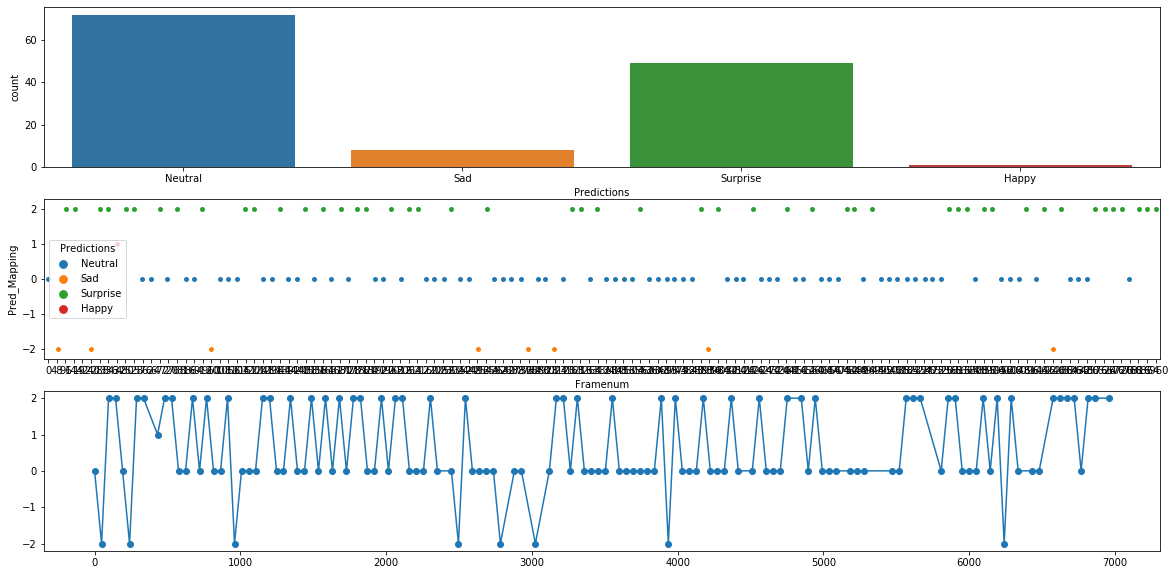

In [20]:
t0=time.time()

fig,(ax1,ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(20,10)

#sns.countplot(y="Predictions", data=data, color="c", ax=ax1)
sns.countplot(x="Predictions", data=data, ax=ax1) #color="c", 
sns.stripplot(x="Framenum", y="Pred_Mapping", data=data, hue="Predictions", ax=ax2)
#sns.boxplot(x="Framenum", y="Predictions", hue="Predictions", data=data, ax=ax2)
#sns.jointplot(x="Framenum", y="Predictions_num", data=data, kind="scatter", color="#4CB391", ax=ax2)

plt.plot("Framenum", "Pred_Mapping", data=data, marker='o')#, color='mediumvioletred')

t1=time.time()
print("Completed. Time taken: ", time.strftime("%H:%M:%S", time.gmtime(t1-t0)))

### Emotion Analysis

In [21]:
data[-5:]

,Framenum,Predictions,Pred_Mapping
125,6720,Surprise,2
126,6768,Neutral,0
127,6816,Surprise,2
128,6864,Surprise,2
129,6960,Surprise,2


In [6]:
# #dataframe slicin
# print(len(data))
# print(round(len(data)/3))
# df_1st_slice = data[:round(len(data)/3)-1]
# df_2nd_slice = data[round(len(data)/3):round(len(data)/3)*2-1]
# df_3rd_slice = data[round(len(data)/3)*2:]
# print(df_1st_slice.shape)
# print(df_2nd_slice.shape)
# print(df_3rd_slice.shape)
# print(df_1st_slice.shape[0]+df_3rd_slice.shape[0]+df_3rd_slice.shape[0])

In [22]:
map=cfg.pos_neg_mapping

#spilt dataframe into 3 section
df_1st_slice = data[:round(len(data)/3)-1]
df_2nd_slice = data[round(len(data)/3):round(len(data)/3)*2-1]
df_3rd_slice = data[round(len(data)/3)*2:]
df_last5_slice = data[-5:]

print("Video duration:", duration, "seconds")
print("Video analysis taken in interval of:", sec, "second(s)")
print("There are", len(data), "data points analysed.")

#print("Most of the time, subject is feeling", data.Predictions.value_counts().index[0],".\n")#, data.Predictions.value_counts().index.tolist()[1:])
count=0
text=""
for i in data.Predictions.value_counts().index.tolist()[:3]:
    #print(data.Predictions.value_counts().index[count]," (%1.2f%%" %data.Predictions.value_counts(1)[count],")")
    text = text + str(data.Predictions.value_counts().index[count]) + " (%1.2f%%" %data.Predictions.value_counts(1)[count] + ")"
    if count!=2:
        text = text + ", "
    count+=1

print("\nThe top 3 emotions exhibited by the subject in descending order are:", text)

minimum = data.Pred_Mapping.min()
maximum = data.Pred_Mapping.max()

if minimum!=maximum:#there is a min and a max, thus fluatation = True
    if minimum>=0:#fluctation within the positive range
        print("Subject appears to be in a postive emotion range.")
    #check if there is any negative (we call neg extreme emotion fluctation)
    elif minimum<0:#fluctation from positive to negative range
        print("\nIt appears that the subject is not emotionally stable.")
#         print("There is fluctuation between", list(map.keys())[list(map.values()).index(data.Pred_Mapping.max())],"(", 
#           data.Pred_Mapping.max(), ")", "and", list(map.keys())[list(map.values()).index(data.Pred_Mapping.min())],"(",data.Pred_Mapping.min(), ").")
#         print("Occurence of", list(map.keys())[list(map.values()).index(data.Pred_Mapping.min())],"at the following frame number:")        
        
#         #query for the lowest neg emotion
#         df_min = data.query("Pred_Mapping=="+ str(minimum))

#         counter=0
#         text=""
#         while counter < len(df_min):
#             #print(df_min.Framenum.iloc[counter])
#             text= text + str(df_min.Framenum.iloc[counter]) 
#             counter+=1
#             if counter != len(df_min):#not at the last item, then append comma ","
#                 text = text +","
    
#         print(text)
        
        #1st section analysis - 
        minimum_1st_third = df_1st_slice.Pred_Mapping.min()
        maximum_1st_third = df_1st_slice.Pred_Mapping.max()
        if minimum_1st_third!=maximum_1st_third: #there is a min and a max, thus fluatation = True
            if minimum_1st_third < 0: #fluctation from positive to negative range
                print("In the 1st third of the video, subject exhibited emotions of ", list(map.keys())[list(map.values()).index(df_1st_slice.Pred_Mapping.max())],"(", 
          df_1st_slice.Pred_Mapping.max(), ")", "and", list(map.keys())[list(map.values()).index(df_1st_slice.Pred_Mapping.min())],"(",df_1st_slice.Pred_Mapping.min(), ").")
        
        #2nd section analysis - 
        minimum_2nd_third = df_2nd_slice.Pred_Mapping.min()
        maximum_2nd_third = df_2nd_slice.Pred_Mapping.max()
        if minimum_2nd_third!=maximum_2nd_third: #there is a min and a max, thus fluatation = True
            if minimum_2nd_third < 0: #fluctation from positive to negative range
                print("In the middle section of the video, subject exhibited emotions of ", list(map.keys())[list(map.values()).index(df_2nd_slice.Pred_Mapping.max())],"(", 
          df_2nd_slice.Pred_Mapping.max(), ")", "and", list(map.keys())[list(map.values()).index(df_2nd_slice.Pred_Mapping.min())],"(",df_2nd_slice.Pred_Mapping.min(), ").")

        #3rd section analysis - 
        minimum_3rd_third = df_3rd_slice.Pred_Mapping.min()
        maximum_3rd_third = df_3rd_slice.Pred_Mapping.max()
        if minimum_3rd_third!=maximum_3rd_third: #there is a min and a max, thus fluatation = True
            if minimum_3rd_third < 0: #fluctation from positive to negative range
                print("In the last third of the video, subject exhibited emotions of ", list(map.keys())[list(map.values()).index(df_3rd_slice.Pred_Mapping.max())],"(", 
          df_3rd_slice.Pred_Mapping.max(), ")", "and", list(map.keys())[list(map.values()).index(df_3rd_slice.Pred_Mapping.min())],"(",df_3rd_slice.Pred_Mapping.min(), ").")
                
        #last 5 seconds
        df_last5_slice
        minimum_last5 = df_last5_slice.Pred_Mapping.min()
        maximum_last5 = df_last5_slice.Pred_Mapping.max()
        if minimum_last5!=maximum_last5: #there is a min and a max, thus fluatation = True
            if minimum_last5 >= 0: #fluctation within positive range
                print("It was only towards the end of the session (last 5 seconds) that subject turns emotionally stable, ranging from", list(map.keys())[list(map.values()).index(df_last5_slice.Pred_Mapping.max())],"(", 
          df_last5_slice.Pred_Mapping.max(), ")", "and", list(map.keys())[list(map.values()).index(df_last5_slice.Pred_Mapping.min())],"(",df_last5_slice.Pred_Mapping.min(), ").")

            if minimum_last5 < 0: #fluctation from positive to negative range
                print("Towards the end of the session (last 5 seconds), subject is still not emotionally stable, ranging from", list(map.keys())[list(map.values()).index(df_last5_slice.Pred_Mapping.max())],"(", 
          df_last5_slice.Pred_Mapping.max(), ")", "and", list(map.keys())[list(map.values()).index(df_last5_slice.Pred_Mapping.min())],"(",df_last5_slice.Pred_Mapping.min(), ").")
                
    


Video duration: 291.81 seconds
Video analysis taken in interval of: 2 second(s)
There are 130 data points analysed.

The top 3 emotions exhibited by the subject in descending order are: Neutral (0.55%), Surprise (0.38%), Sad (0.06%)

It appears that the subject is not emotionally stable.
In the 1st third of the video, subject exhibited emotions of  Surprise ( 2 ) and Sad ( -2 ).
In the middle section of the video, subject exhibited emotions of  Surprise ( 2 ) and Sad ( -2 ).
In the last third of the video, subject exhibited emotions of  Surprise ( 2 ) and Sad ( -2 ).
It was only towards the end of the session (last 5 seconds) that subject turns emotionally stable, ranging from Surprise ( 2 ) and Neutral ( 0 ).


In [8]:
# import config as cfg
# duration=220
# sec=1

Video duration: 48.26 seconds<br>
Video frame analysis taken in interval of: 1 seconds<br>
There are 49 data points analysed.<br>

The top 3 emotions exhibited by the subject in descending order are surprise (XX% of the      time), neutral (XX%) and sad (XX%)
<br><br>
Assuming that this is a video resume, it appears that the subject is not emotionally stable.    He/She exhibited wild swings of emotions between surprise and sad throughout the first      two-thirds of the interview. Around the middle of the interview, there were also instances  where he/she appeared angry. It was only towards the end of the session that he/she                       became more emotionally stable

